In [1]:
#import modules
import xarray as xr
import numpy as np
import pandas as pd
import salem
import plotly.graph_objects as go

import sys
sys.path.append('/exports/csce/datastore/geos/users/s1878599/python_code/')
from WRFChemToolkit.analysis import aerosols_202 as aer, plots as pt, statistics as st, IGP as igp

import warnings
warnings.filterwarnings('ignore')

## GET DATA

In [2]:
#Get IGP data
baut_pth='/geos/d21/s1878599/IGP/outputs/autumn/base/wrfout*.nc'
aaut_pth='/geos/d21/s1878599/IGP/outputs/autumn/ptrb_anthro/wrfout*.nc'
faut_pth='/geos/d21/s1878599/IGP/outputs/autumn/ptrb_fire/wrfout*.nc'


shp_path = '/exports/csce/datastore/geos/users/s1878599//python_code/gadm_data/IGP/IGP.shp'

baIGP =igp.get_IGP(baut_pth, shp_path)
aaIGP =igp.get_IGP(aaut_pth, shp_path)
faIGP =igp.get_IGP(faut_pth, shp_path)

In [3]:
def get_aerIGP(d):
    aer_IGP={}
    for adm, val in d.items():
        aer_IGP.update({adm : aer.get_aerosols(val)})
    return aer_IGP

In [4]:
#IGP aerosols
b_aer=get_aerIGP(baIGP)
f_aer=get_aerIGP(faIGP)
a_aer=get_aerIGP(aaIGP)

## DEFINE FUNCTIONS

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.colorbar import colorbar
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.io.shapereader as shpreader

In [6]:
def set_formatter(axes):
    for ax in axes:
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=0.5, color='k', alpha=0.4, linestyle='-')
        gl.xlabels_top = False
        gl.ylabels_right = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'size': 10, 'color': 'gray'}
        gl.ylabel_style = {'size': 10, 'color': 'grey'} 

        
def set_admin(axes, shp_path):
    for ax,shp in zip(axes,shp_path):
            admin = list(shpreader.Reader(shp).geometries())
            # Add data from Global Administrative Areas Dataset GDAM https://gadm.org/index.html
            ax.add_geometries(admin, ccrs.PlateCarree(),
                      edgecolor='black', facecolor='none', alpha=1, lw=0.75)
 
 # set the colormap and centre the colorbar
class MidpointNormalize(mpl.colors.Normalize):
    """Normalise the colorbar."""
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))


def subIGP(ads,rds, title=None, cmap="OrRd", levs=10, figsize=[10, 15]):

    fig, axes =plt.subplots(nrows=3,ncols=2,figsize=figsize, subplot_kw={'projection': ccrs.PlateCarree()})
    u_shp="/exports/csce/datastore/geos/users/s1878599/python_code/gadm_data/IGP/U_IGP.shp"
    m_shp="/exports/csce/datastore/geos/users/s1878599/python_code/gadm_data/IGP/M_IGP.shp"
    l_shp= "/exports/csce/datastore/geos/users/s1878599/python_code/gadm_data/IGP/L_IGP.shp"
    shp_path=(u_shp,u_shp,m_shp,m_shp,l_shp,l_shp)
    
    set_formatter(axes.flatten())
    set_admin(axes.flatten(), shp_path)
    
    #Getting values.
    va=list(ads.values())
    vr=list(rds.values())
    

    import math 
    vmin_a=np.array([np.nanmin(va[0][2]),np.nanmin(va[1][2]),np.nanmin(va[2][2])]).min()       
    print(vmin_a) # Get the max value in the array to plot.
    vmax_a =np.array([np.nanmax(va[0][2]),np.nanmax(va[1][2]),np.nanmax(va[2][2])]).max()       
    print(vmax_a)
    
    vmin_r=np.array([np.nanmin(vr[0][2]),np.nanmin(vr[1][2]),np.nanmin(vr[2][2])]).min()       
    print(vmin_r) # Get the max value in the array to plot.
    vmax_r =np.array([np.nanmax(vr[0][2]),np.nanmax(vr[1][2]),np.nanmax(vr[2][2])]).max()       
    print(vmax_r)
    
    la = np.linspace(vmin_a, vmax_a, levs)  # number of levels for which divide the bar. Customised. 
    lr = np.linspace(vmin_r, vmax_r, levs)                                              
    # abs diff
    ua=axes[0,0].contourf(va[0][0],va[0][1],va[0][2],transform=ccrs.PlateCarree(),cmap=cmap,levels=la, vmin=vmin_a,vmax=vmax_a) #U IGP values.
    ma=axes[1,0].contourf(va[1][0],va[1][1],va[1][2],transform=ccrs.PlateCarree(),cmap=cmap,levels=la, vmin=vmin_a,vmax=vmax_a) #M IGP values.
    la=axes[2,0].contourf(va[2][0],va[2][1],va[2][2],transform=ccrs.PlateCarree(),cmap=cmap,levels=la, vmin=vmin_a,vmax=vmax_a)
    
    #rel diff
    ur=axes[0,1].contourf(vr[0][0],vr[0][1],vr[0][2],transform=ccrs.PlateCarree(),cmap="RdBu_r",levels=lr, vmin=vmin_r,vmax=vmax_r,norm=MidpointNormalize(vmin_r, vmax_r, 0.)) #U IGP values.
    mr=axes[1,1].contourf(vr[1][0],vr[1][1],vr[1][2],transform=ccrs.PlateCarree(),cmap="RdBu_r",levels=lr, vmin=vmin_r,vmax=vmax_r,norm=MidpointNormalize(vmin_r, vmax_r, 0.)) #M IGP values.
    lr=axes[2,1].contourf(vr[2][0],vr[2][1],vr[2][2],transform=ccrs.PlateCarree(),cmap="RdBu_r",levels=lr, vmin=vmin_r,vmax=vmax_r,norm=MidpointNormalize(vmin_r, vmax_r, 0.))
    

    axes[0,0].set_title("NET DIFFIRENCE")
    axes[0,1].set_title("% DIFFERENCE")
 
    #set colorbar
    cax, kw= mpl.colorbar.make_axes([ax for ax in axes.flat], orientation="horizontal", pad=0.075)
    cbar=fig.colorbar(ua, cax=cax, **kw)
    cbar1=fig.colorbar(ua, ax=axes[2,0],orientation="horizontal")
    cbar1.set_label("diff ug/m3")
    cbar2=fig.colorbar(ur, ax=axes[2,1], orientation="horizontal")
    cbar2.set_label("diff %")
    if title is not None:
        fig.suptitle(title, fontsize=20)
        
    fig.tight_layout()
    fig.show()

In [7]:
# latitutes and longitudes for diffrent part of IGP

u_long = b_aer['U_IGP'].lon.values
u_lat =  b_aer['U_IGP'].lat.values

m_long = b_aer['M_IGP'].lon.values
m_lat =  b_aer['M_IGP'].lat.values

l_long = b_aer['L_IGP'].lon.values
l_lat =  b_aer['L_IGP'].lat.values

In [8]:
#surface time average values of relative difference
def get_reldiffv_plot(bds,pds,var):
 
    ur= ((pds['U_IGP'][var]/bds['U_IGP'][var]-1)*100).mean(dim='time')[0, :, :]
    mr= ((pds['M_IGP'][var]/bds['M_IGP'][var]-1)*100).mean(dim='time')[0, :, :]
    lr= ((pds['L_IGP'][var]/bds['L_IGP'][var]-1)*100).mean(dim='time')[0, :, :]

    # plot dictionary
    plot_data={}
    plot_data.update({"UPPER IGP": (u_long, u_lat,ur)})
    plot_data.update({"MIDDLE IGP":(m_long, m_lat,mr)})
    plot_data.update({"LOWER IGP":(l_long, l_lat, lr)})
    
    return plot_data

In [9]:
#surface time average values of difference
def get_diffv_plot(bds,pds,var):

    ud= (pds['U_IGP'][var]-bds['U_IGP'][var]).mean(dim='time')[0, :, :]
    md= (pds['M_IGP'][var]-bds['M_IGP'][var]).mean(dim='time')[0, :, :]
    ld= (pds['L_IGP'][var]-bds['L_IGP'][var]).mean(dim='time')[0, :, :]

    # plot dictionary
    plot_data={}
    plot_data.update({"UPPER IGP": (u_long, u_lat,ud)})
    plot_data.update({"MIDDLE IGP":(m_long, m_lat,md)})
    plot_data.update({"LOWER IGP":(l_long, l_lat, ld)})
    
    return plot_data


# FIRE PERTURBATION

-0.28392848
3.3518088
-0.4196945
1.2139927


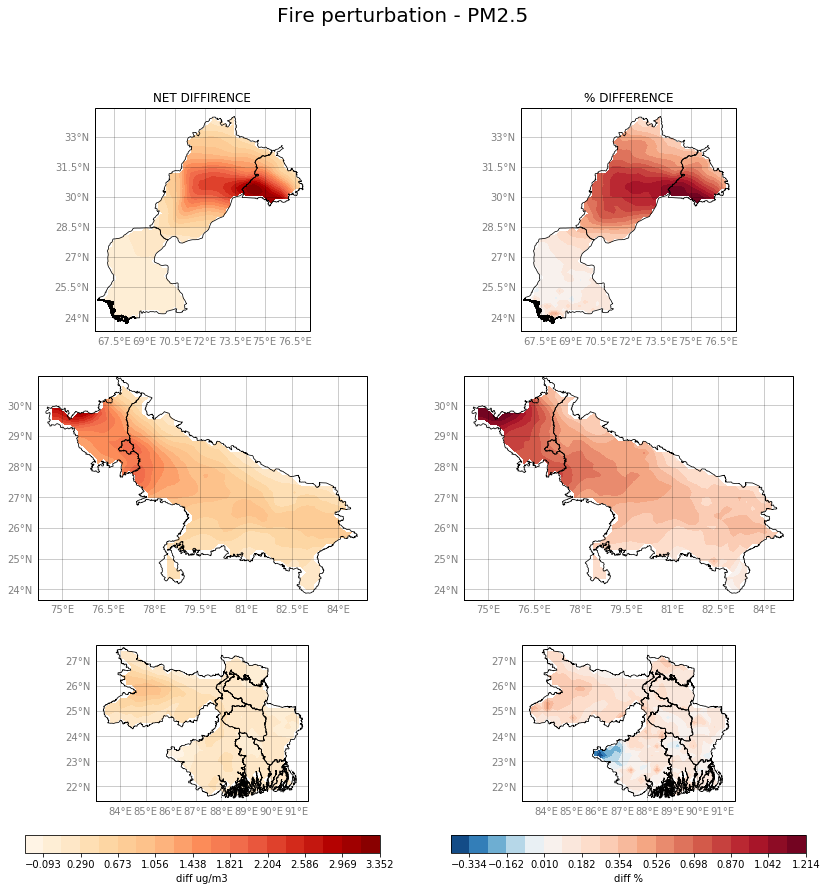

In [14]:
#pm2.5
pm25d= get_diffv_plot(b_aer,f_aer, "PM2_5_DRY")
pm25r= get_reldiffv_plot(b_aer,f_aer, "PM2_5_DRY")
subIGP(pm25d,pm25r, title="Fire perturbation - PM2.5", cmap="OrRd", levs=20, figsize=[14, 14])

-0.49749923
0.9397514
-0.6588454
2.091105


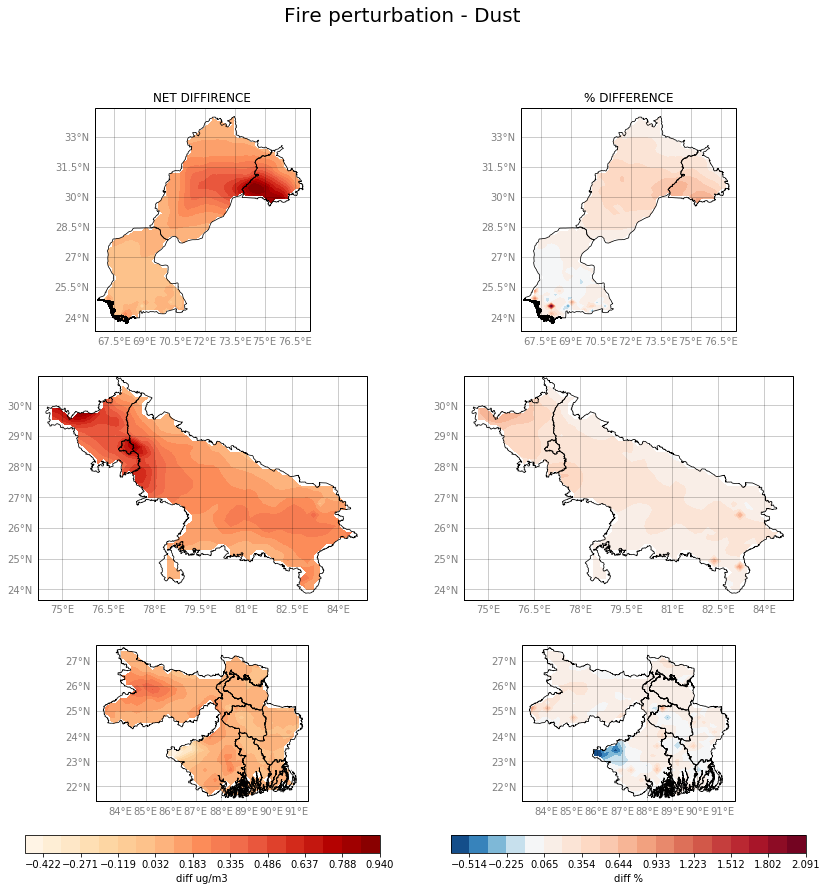

In [15]:
#dust
dustd= get_diffv_plot(b_aer,f_aer, "pm10_dust")
dustr= get_reldiffv_plot(b_aer,f_aer, "pm10_dust")
subIGP(dustd,dustr, title="Fire perturbation - Dust", cmap="OrRd", levs=20, figsize=[14, 14])

-0.012812907
0.24663155
-0.50350726
1.2836778


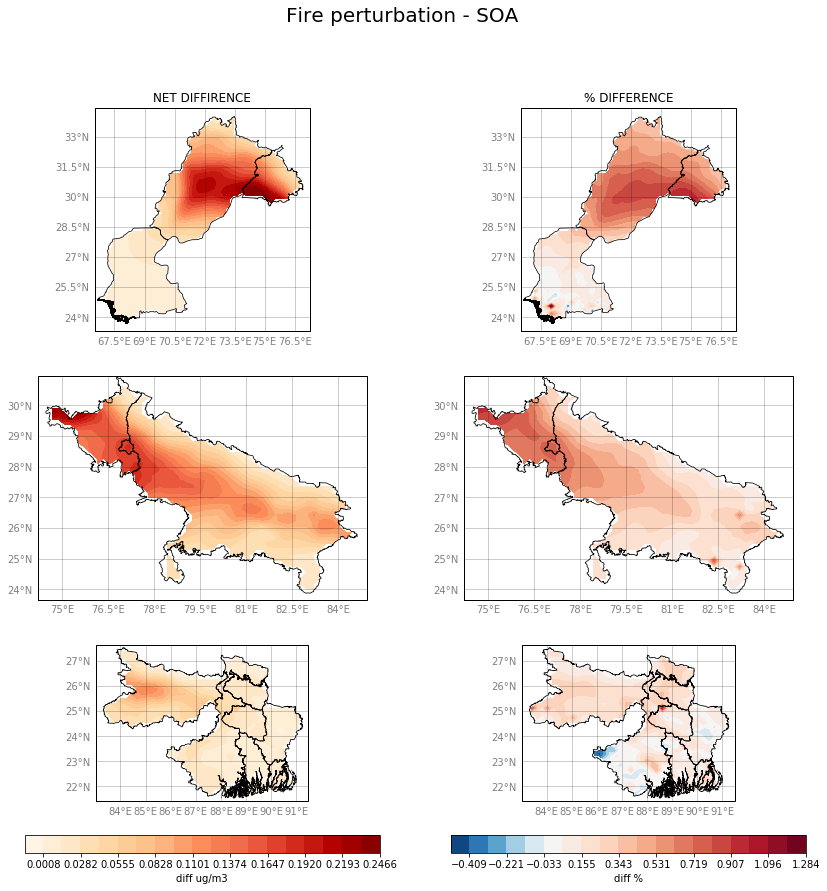

In [18]:
#SOA
soad= get_diffv_plot(b_aer,f_aer, "pm10_SOA")
soar= get_reldiffv_plot(b_aer,f_aer, "pm10_SOA")
subIGP(soad,soar, title="Fire perturbation - SOA", cmap="OrRd", levs=20, figsize=[14, 14])

-0.0739162
1.1511248
-0.47788602
2.013713


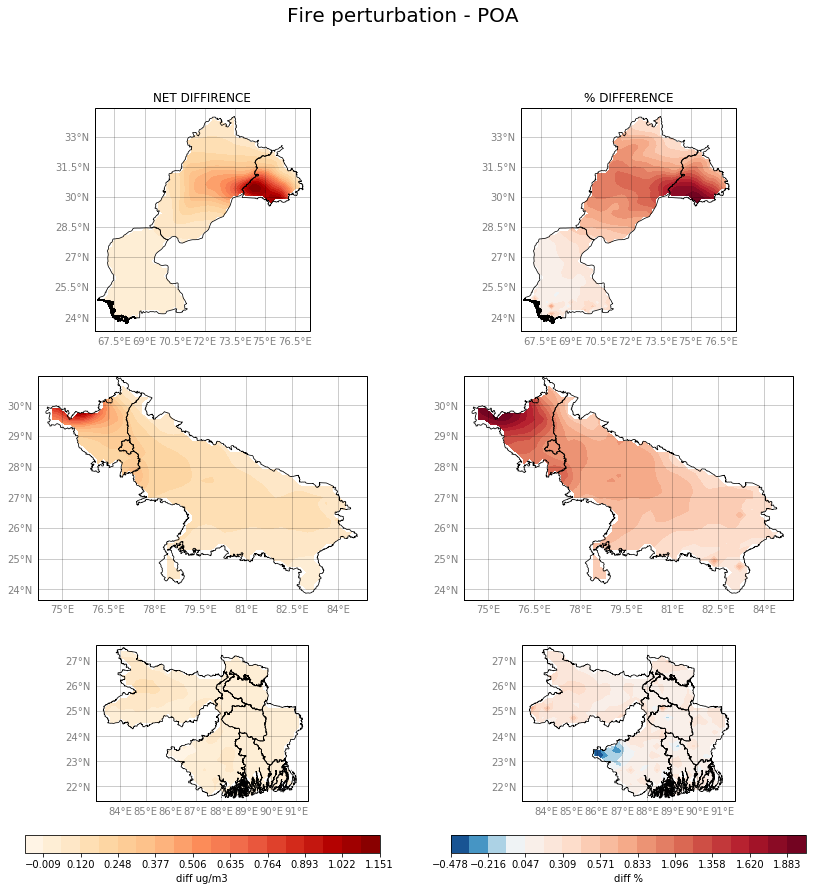

In [16]:
#POA
poad= get_diffv_plot(b_aer,f_aer, "pm10_POA")
poar= get_reldiffv_plot(b_aer,f_aer, "pm10_POA")
subIGP(poad,poar, title="Fire perturbation - POA", cmap="OrRd", levs=20, figsize=[14, 14])

-0.03554555
1.1883445
-0.6507385
4.4916773


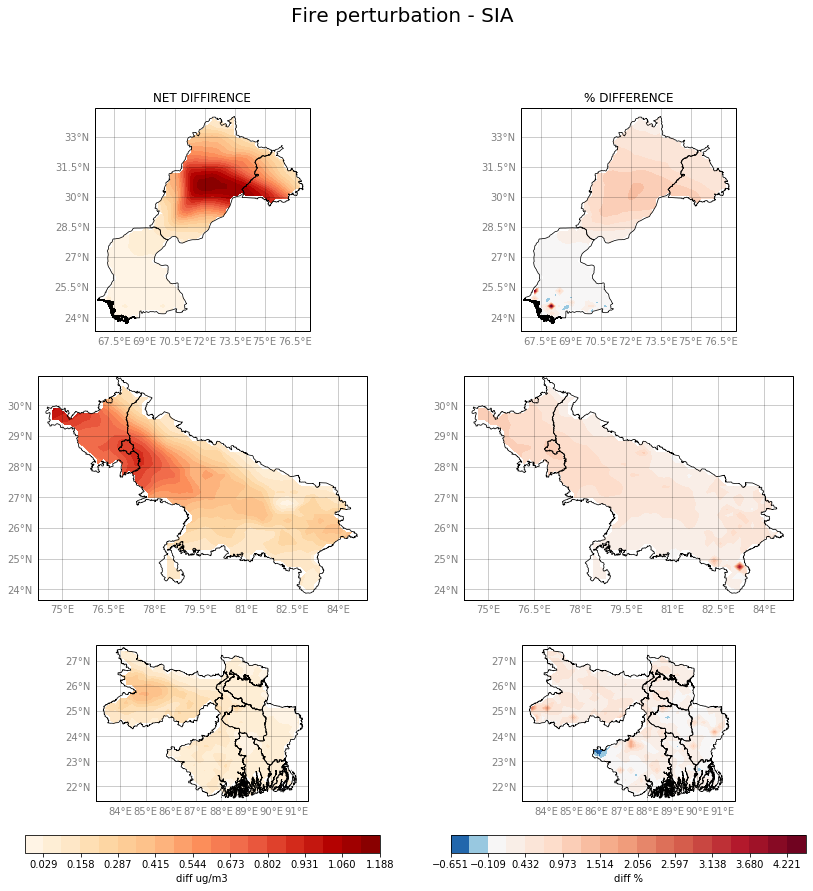

In [19]:
#seasalt
siad= get_diffv_plot(b_aer,f_aer, "pm10_SIA")
siar= get_reldiffv_plot(b_aer,f_aer, "pm10_SIA")
subIGP(siad,siar, title="Fire perturbation - SIA", cmap="OrRd", levs=20, figsize=[14, 14])

-0.05408808
0.21324325
-0.5492005
1.4567882


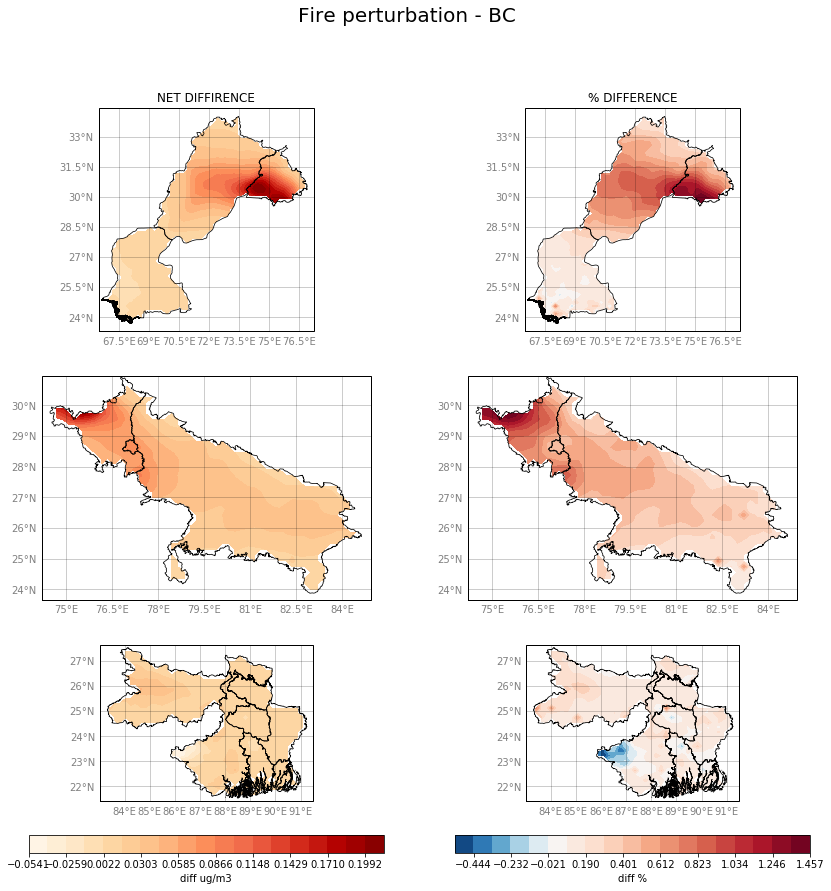

In [20]:
#bc
bcd= get_diffv_plot(b_aer,f_aer, "pm10_bc")
bcr= get_reldiffv_plot(b_aer,f_aer, "pm10_bc")
subIGP(bcd,bcr, title="Fire perturbation - BC", cmap="OrRd", levs=20, figsize=[14, 14])

-0.07125572
0.040218603
-0.96001816
10.402403


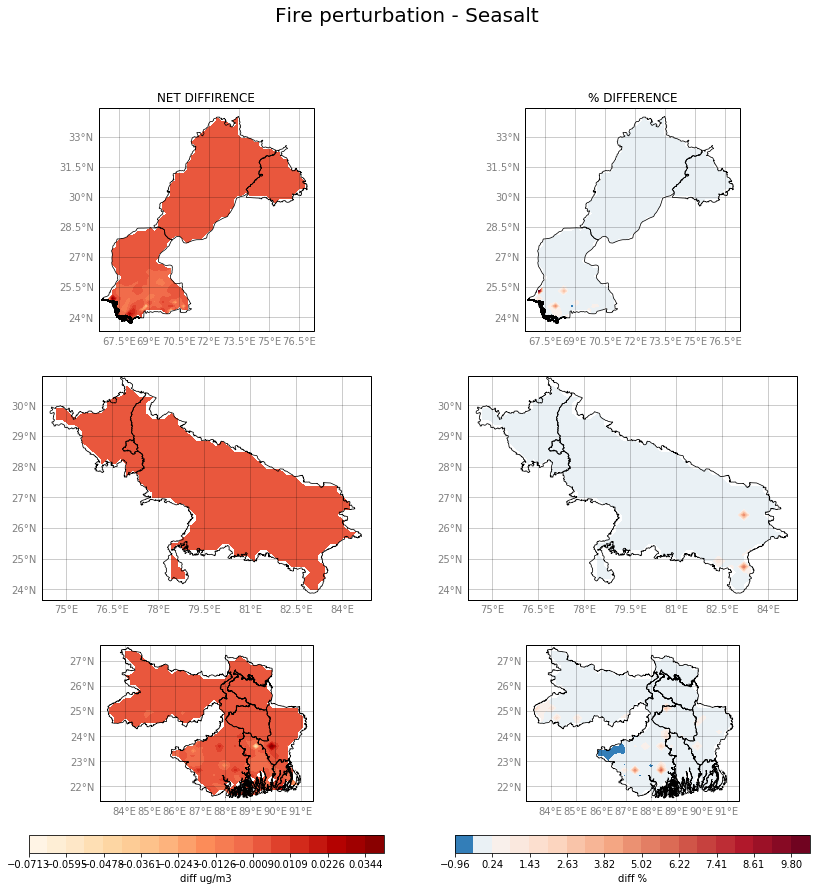

In [21]:
#seasalt
sead= get_diffv_plot(b_aer,f_aer, "pm10_sea")
sear= get_reldiffv_plot(b_aer,f_aer, "pm10_sea")
subIGP(sead,sear, title="Fire perturbation - Seasalt", cmap="OrRd", levs=20, figsize=[14, 14])

# ANTHROPOGENIC PERTURBATION

0.38347057
21.349503
1.1986738
6.9101596


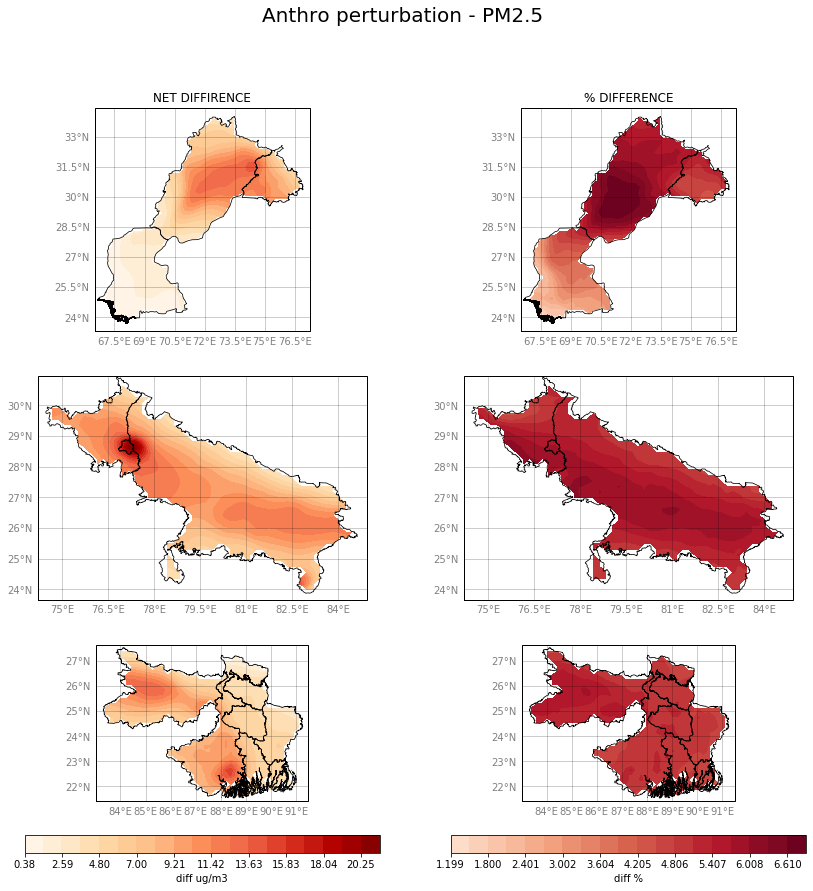

In [22]:
#pm2.5
pm25d= get_diffv_plot(b_aer,a_aer, "PM2_5_DRY")
pm25r= get_reldiffv_plot(b_aer,a_aer, "PM2_5_DRY")
subIGP(pm25d,pm25r, title="Anthro perturbation - PM2.5", cmap="OrRd", levs=20, figsize=[14, 14])

0.08136449
6.4755974
0.6948249
15.911018


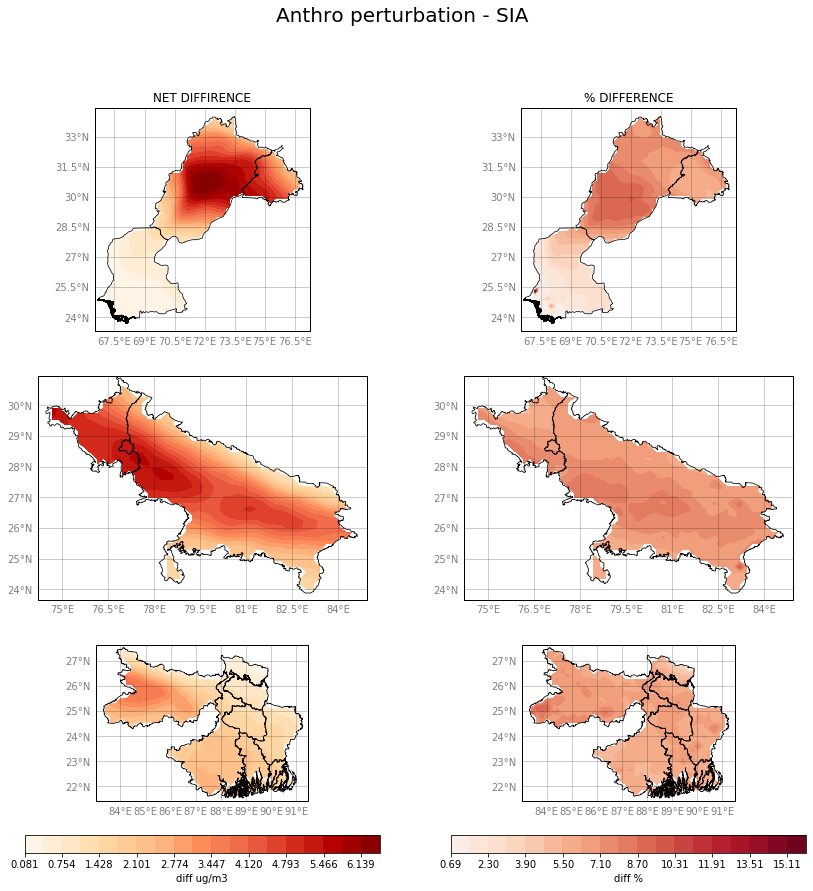

In [23]:
#SIA
siad= get_diffv_plot(b_aer,a_aer, "pm10_SIA")
siar= get_reldiffv_plot(b_aer,a_aer, "pm10_SIA")
subIGP(siad,siar, title="Anthro perturbation - SIA", cmap="OrRd", levs=20, figsize=[14, 14])

-0.07159618
0.05155013
-1.1284256
33.331894


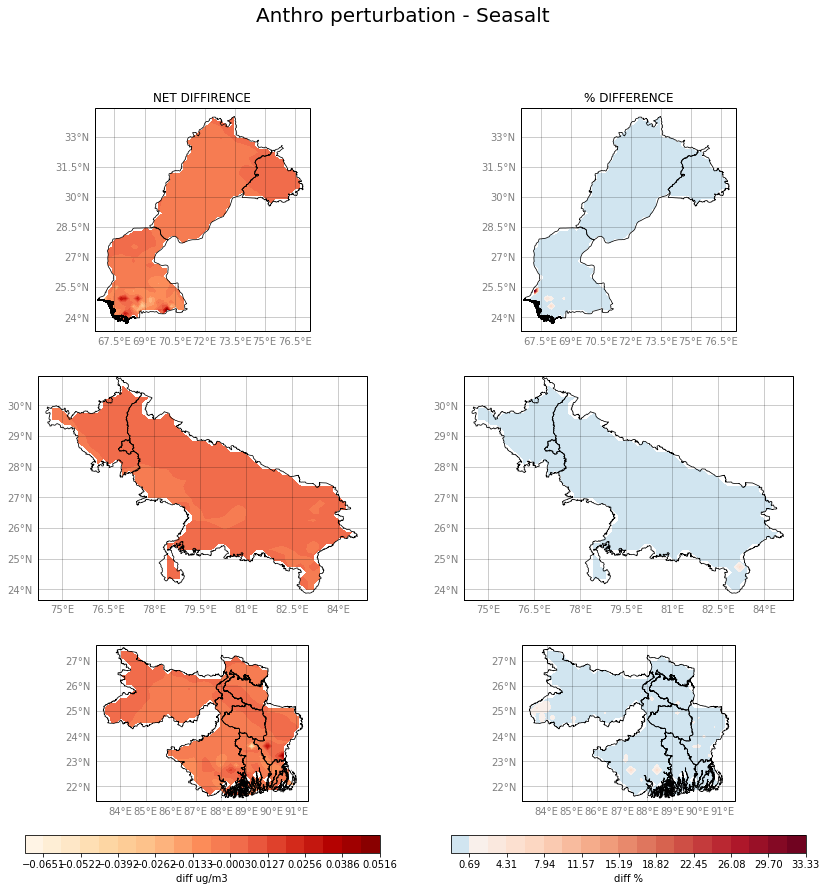

In [24]:
#sea salt
sead= get_diffv_plot(b_aer,a_aer, "pm10_sea")
sear= get_reldiffv_plot(b_aer,a_aer, "pm10_sea")
subIGP(sead,sear, title="Anthro perturbation - Seasalt", cmap="OrRd", levs=20, figsize=[14, 14])

0.02038011
1.403129
1.6793302
5.875642


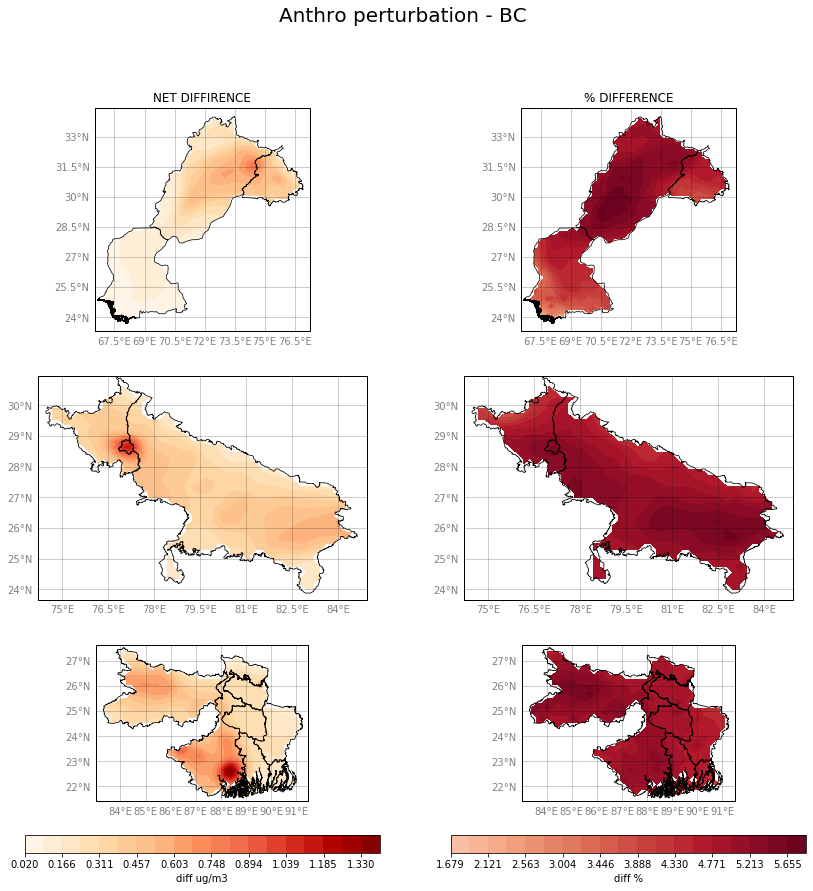

In [25]:
#bc
bcd= get_diffv_plot(b_aer,a_aer, "pm10_bc")
bcr= get_reldiffv_plot(b_aer,a_aer, "pm10_bc")
subIGP(bcd,bcr, title="Anthro perturbation - BC", cmap="OrRd", levs=20, figsize=[14, 14])

0.058579024
2.899937
1.3070066
5.7011237


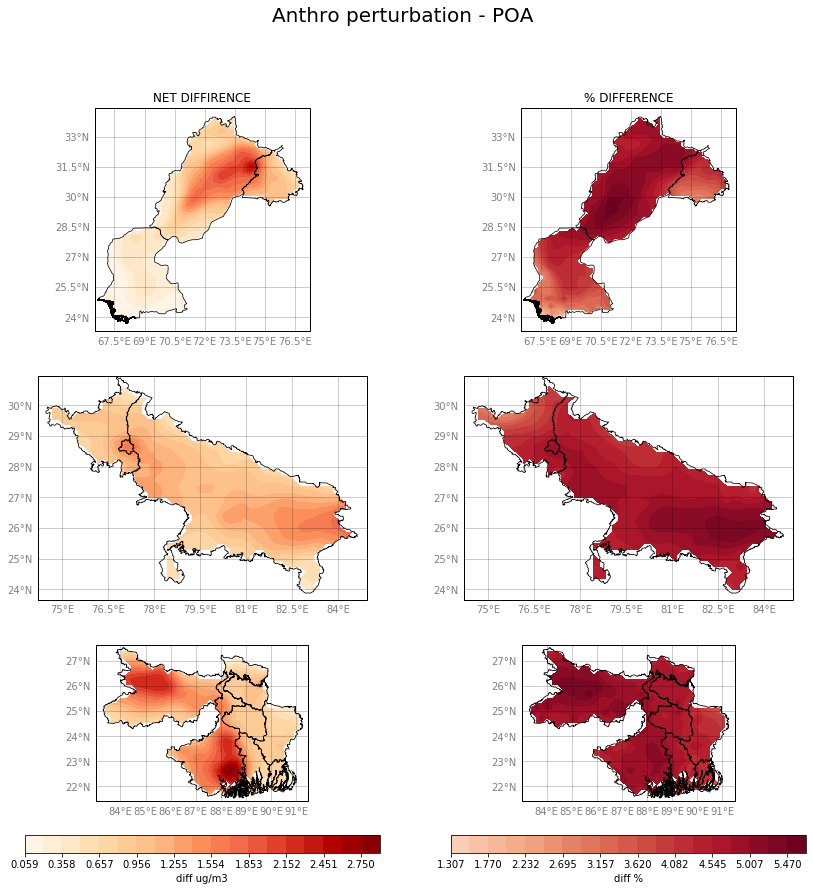

In [29]:
#POA
poad= get_diffv_plot(b_aer,a_aer, "pm10_POA")
poar= get_reldiffv_plot(b_aer,a_aer, "pm10_POA")
subIGP(poad,poar, title="Anthro perturbation - POA", cmap="OrRd", levs=20, figsize=[14, 14])

0.04139858
1.5427141
2.4288676
6.378949


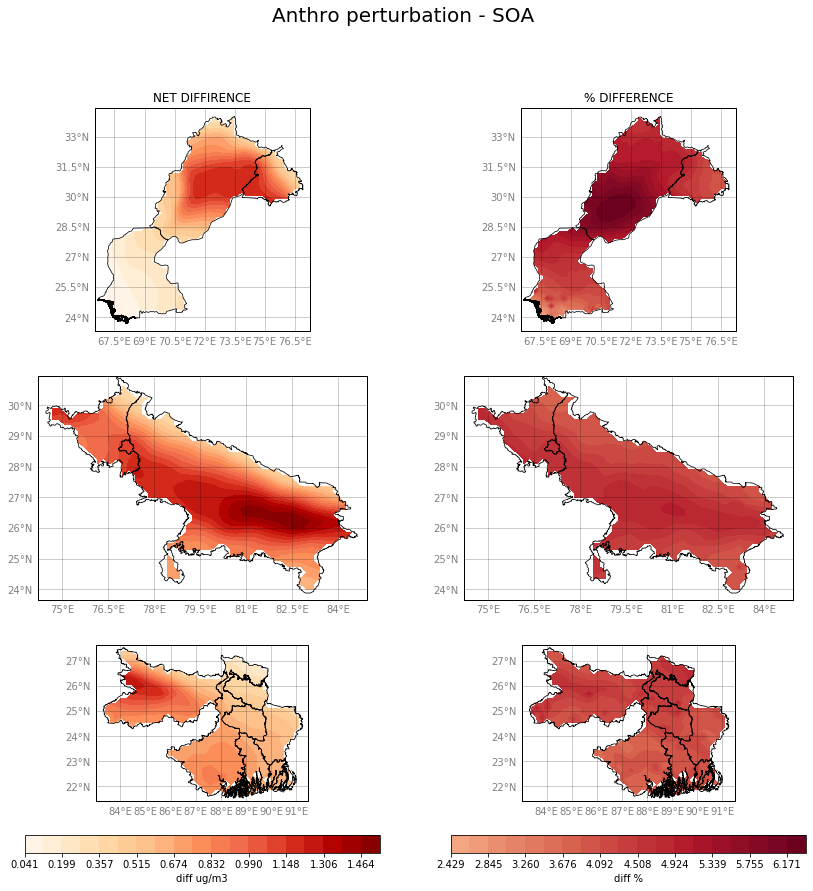

In [27]:
#SOA
soad= get_diffv_plot(b_aer,a_aer, "pm10_SOA")
soar= get_reldiffv_plot(b_aer,a_aer, "pm10_SOA")
subIGP(soad,soar, title="Anthro perturbation - SOA", cmap="OrRd", levs=20, figsize=[14, 14])

0.15223838
23.990906
0.8635176
6.0246983


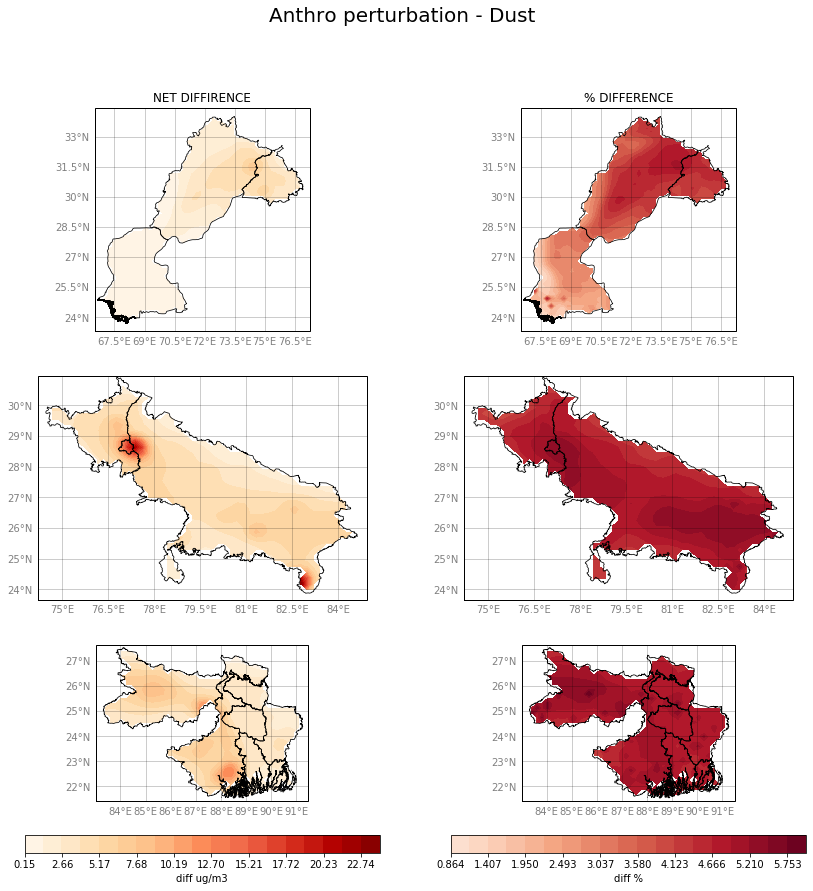

In [28]:
#dust
dustd= get_diffv_plot(b_aer,a_aer, "pm10_dust")
dustr= get_reldiffv_plot(b_aer,a_aer, "pm10_dust")
subIGP(dustd,dustr, title="Anthro perturbation - Dust", cmap="OrRd", levs=20, figsize=[14, 14])

# SENSITIVITY

In [10]:
#emissions fire
fire ='/geos/d21/s1878599/IGP/inputs/autumn/base/wrffirechemi*'
dsfb = xr.open_mfdataset(fire, concat_dim='Time')
fireptrb ='/geos/d21/s1878599/IGP/inputs/autumn/ptrb_fire/p5_wrffirechemi*'
dsfp = xr.open_mfdataset(fire, concat_dim='Time')

In [12]:
#Adding XLAT and XLONG to dataset
datapath ='/geos/d21/s1878599/IGP/outputs/autumn/base/wrfout_d01_2017-10-18_00:00:00_.nc'
ds = xr.open_dataset(datapath)
#reshaping XLAT and LONG to ds_fire sizes.
lat =np.resize(ds.XLAT.values,dsfb.ebu_in_co.shape)
long =np.resize(ds.XLONG.values,dsfb.ebu_in_co.shape)

#adding to ds_fire
dsfb['XLAT'] = xr.DataArray(lat, dims = dsfb.dims)
dsfb['XLONG'] = xr.DataArray(long, dims = dsfb.dims)

dsfp['XLAT'] = xr.DataArray(lat, dims = dsfp.dims)
dsfp['XLONG'] = xr.DataArray(long, dims = dsfp.dims)

In [15]:
dsfb

<xarray.Dataset>
Dimensions:          (Time: 720, emissions_zdim_stag: 1, south_north: 119, west_east: 159)
Dimensions without coordinates: Time, emissions_zdim_stag, south_north, west_east
Data variables:
    Times            (Time) |S19 dask.array<chunksize=(1,), meta=np.ndarray>
    ebu_in_co        (Time, emissions_zdim_stag, south_north, west_east) float32 dask.array<chunksize=(1, 1, 119, 159), meta=np.ndarray>
    ebu_in_no        (Time, emissions_zdim_stag, south_north, west_east) float32 dask.array<chunksize=(1, 1, 119, 159), meta=np.ndarray>
    ebu_in_so2       (Time, emissions_zdim_stag, south_north, west_east) float32 dask.array<chunksize=(1, 1, 119, 159), meta=np.ndarray>
    ebu_in_bigalk    (Time, emissions_zdim_stag, south_north, west_east) float32 dask.array<chunksize=(1, 1, 119, 159), meta=np.ndarray>
    ebu_in_bigene    (Time, emissions_zdim_stag, south_north, west_east) float32 dask.array<chunksize=(1, 1, 119, 159), meta=np.ndarray>
    ebu_in_c2h4      (Time, emis

In [20]:
#separate gas from aeros ols
f_gas = ["ebu_in_co",   "ebu_in_no",     "ebu_in_so2",    "ebu_in_bigalk","ebu_in_bigene",  "ebu_in_c2h4", "ebu_in_c2h5oh", "ebu_in_c2h6",
        "ebu_in_c3h8",   "ebu_in_c3h6",   "ebu_in_ch2o",  "ebu_in_ch3cho","ebu_in_ch3coch3","ebu_in_ch3oh","ebu_in_mek",    "ebu_in_toluene",
        "ebu_in_benzene","ebu_in_xylenes","ebu_in_xylene","ebu_in_nh3",   "ebu_in_no2",     "ebu_in_open", "ebu_in_c10h16", "ebu_in_ch3cooh",
        "ebu_in_cres",   "ebu_in_glyald", "ebu_in_mgly",  "ebu_in_acetol","ebu_in_isop",    "ebu_in_macr", "ebu_in_mvk",    "ebu_in_apin",
         "ebu_in_ch3cn", "ebu_in_hcn",    "ebu_in_hcooh",  "ebu_in_c2h2"
        ]

f_aer = ["ebu_in_oc","ebu_in_bc","ebu_in_sulf","ebu_in_pm25","ebu_in_pm10"]

In [23]:
fb_gas = dsfb[f_gas]
fp_gas = dsfp[f_gas]
fb_aer =dsfb[f_aer]
fp_aer =dsfp[f_aer]

In [27]:
#add sum emissions

def get_sum_emi(ds, lis):
    
    ds["tot_emi"]=ds[lis[0]]
    for var in lis:
        if var !=lis[0]: 
            ds["tot_emi"]=ds["tot_emi"]+ds[var]

In [49]:
get_sum_emi(fb_gas,f_gas)
get_sum_emi(fp_gas,f_gas)

get_sum_emi(fb_aer,f_aer)
get_sum_emi(fp_aer,f_aer)

In [50]:
#GET IGP emissions


In [ ]:
# sensitivity to all IGP emissions
def get_senstivity_plot(bds,pds,bemi,pemi,var):
    
    #time average of concentration difference
    ur= ((pds['U_IGP'][var]-bds['U_IGP'][var]).mean(dim='time')[0, :, :]
    mr= ((pds['M_IGP'][var]-bds['M_IGP'][var]).mean(dim='time')[0, :, :]
    lr= ((pds['L_IGP'][var]-bds['L_IGP'][var]).mean(dim='time')[0, :, :]
    
    #time average of sum emissions difference  
    ur= ((pemi['U_IGP'][var]-bemi['U_IGP'][var]).mean(dim='time')[0, :, :]
    mr= ((pemi['M_IGP'][var]-bemi['M_IGP'][var]).mean(dim='time')[0, :, :]
    lr= ((pemi['L_IGP'][var]-bemi['L_IGP'][var]).mean(dim='time')[0, :, :]

    # plot dictionary
    plot_data={}
    plot_data.update({"UPPER IGP": (u_long, u_lat,ur)})
    plot_data.update({"MIDDLE IGP":(m_long, m_lat,mr)})
    plot_data.update({"LOWER IGP":(l_long, l_lat, lr)})
    
    return plot_data
